# Presidio

### Summary  
- It is an open-source context-aware **PII data protection and de-identification SDK** for text and images    
    - Note: **PII stands for Personally Identifiable Information** is any information connected to a specific individual that can be used to uncover that individual's identity, such as their social security number, full name, or email address. 
- " It provides fast de-identification and **anonymization modules** for private entities in text such as `credit card numbers, (person) names, locations, social security numbers, bitcoin wallets, US phone numbers, financial data and more`."  
- See [a full list of supported PII entities by Presidio](https://microsoft.github.io/presidio/supported_entities/)
- See [Presidio GitHub Repo](https://github.com/microsoft/presidio) and [Tutorial Notebook](https://microsoft.github.io/presidio/samples/python/customizing_presidio_analyzer/)   
### Benefits
- A free, easy-to-use and powerful tool to preserve **Privacy** for enterprise AI applications & services
- The open-source MIT License does **allow commercial use**  
- **Extensible and customizable in PII (de-)identification** to a specific business need (i.e. can define and protect your own 'private entities')  
    - It can be easily extended to support detection of additional PII entities (see [this tutorial on adding new PII recognizers](https://microsoft.github.io/presidio/analyzer/adding_recognizers/) for more info) 
- **Multi-language**, multi-platform support for (fully-/semi-)automated PII de-identification flows  
    - Refer to the [multi-language support](https://microsoft.github.io/presidio/analyzer/languages/) for more info

### Features
- Presidio can help identify sensitive/PII data in **un/structured text**
- **Predefined or custom PII recognizers** leveraging `Named Entity Recognition (NER), deny list, regular expressions, rule-based logic and checksum` with relevant context    
- Options for connecting to **external** PII detection models
- Multiple usage options, from Python or PySpark workloads through Docker to Kubernetes
- Module for **redacting PII text in images** (standard image types and DICOM medical images).

## Installation
- Using pip
- 
Using Docke  
- 
From sour     

### Using pip
#### PII anonymization on text
- Install the `presidio-analyzer` and `presidio-anonymizer` packages
#### PII redaction in image
- Pre-requisite: Install [Tesseract OCR](https://github.com/tesseract-ocr/tesseract#installing-tesseract) by following the instructions on how to install it for your operating system.s
- Install the `presidio-image-redactor` package2

In [ ]:
! pip install presidio_analyzer
! pip install presidio_anonymizer

# Presidio analyzer requires a spaCy language model.
! python -m spacy download en_core_web_lg

In [ ]:
! brew install tesseract

In [ ]:
! pip install presidio_image_redactor

# Presidio image redactor uses the presidio-analyzer
# which requires a spaCy language model:
! python -m spacy download en_core_web_lg

# Testing
## 1. Identify & Anonymize PII in text
- Presidio has two main modules for anonymizing PII in text in two steps:    
- 1.1 `Presidio analyzer: a Python-based service for identifying PII entities in text`  
    - During analysis, it runs multiple Recognizers, each one in charge of detecting one or more specific PII entities by using different mechanisms, such as `regular expressions, deny lists, checksum, rule-based logic, NER ML models and context from surrounding words`  
    - It comes with a set of predefined recognizers, but can easily be extended with other custom recognizers
- 1.2 `Presidio anonymizer: Anonymize detected PII entities using different operators (e.g. redact, replace, hash or encrypt)`  
    - Anonymizer has multiple operators, each one can be used to anonymize the PII entity in a different way.   
    - Additionally, it can be used to de-anonymize an already anonymized entity (For example, decrypt an encrypted entity)   
- In most cases, we would run the Presidio analyzer to detect where PII entities exist, and then the Presidio anonymizer to remove those using specific operators

[Several ways to post an image in Jupyter notebooks](https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o) 

![Image of Presidio text anonymization](https://microsoft.github.io/presidio/assets/analyze-anonymize.png)

#### A quick E2E test sample:
- Note: When initializing the `AnalyzerEngine`, Presidio loads `all available pre-defined recognizers, including the NlpEngine` used to detect entities, and extract tokens, lemmas and other linguistic features


In [1]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

text="My name is David Smith, I am living in New York and my phone number is 802-333-7777"

# Set up the analyzer engine, loads the NLP module (spaCy model by default) and other PII recognizers
analyzer = AnalyzerEngine()
# Call analyzer to get results
results = analyzer.analyze(text=text,
                           entities=["PHONE_NUMBER", "PERSON", "LOCATION"],
                           language='en')
print(f'analyzer_results:\n{results}')

# Analyzer results are passed to the AnonymizerEngine for anonymization
anonymizer = AnonymizerEngine()
anonymized_text = anonymizer.anonymize(text=text,analyzer_results=results)
print(f'anonymized_text:\n{anonymized_text}')

analyzer_results:
[type: PERSON, start: 11, end: 22, score: 0.85, type: LOCATION, start: 39, end: 47, score: 0.85, type: PHONE_NUMBER, start: 71, end: 83, score: 0.75]
anonymized_text:
text: My name is <PERSON>, I am living in <LOCATION> and my phone number is <PHONE_NUMBER>
items:
[
    {'start': 70, 'end': 84, 'entity_type': 'PHONE_NUMBER', 'text': '<PHONE_NUMBER>', 'operator': 'replace'},
    {'start': 36, 'end': 46, 'entity_type': 'LOCATION', 'text': '<LOCATION>', 'operator': 'replace'},
    {'start': 11, 'end': 19, 'entity_type': 'PERSON', 'text': '<PERSON>', 'operator': 'replace'}
]



In [2]:
type(anonymized_text.text)

str

### 1.1 Presidio Analyzer (Module)
### 1.1.a AI Explainability - Analyzer's decision process
#### What is it
Analyzer's decision process exposes following information: 
- Which recognizer detected the PII entity  
- Which regex pattern was used  
- Interpretability mechanisms in ML models  
- Which context words improved the score  
- Confidence scores before and after each step
- And more.
#### How to use
The decision process can be used in two ways:
- 1) The decision process can be returned as part of the `/analyze` response.
- 2) Analyzer can log its decision process into a designated logger (e.g. `stdout`, which allows you to investigate a specific api request, by exposing a unique `correlation-id` as part of the api response headers with following log format:  
`[Date Time][decision_process][Log Level][Unique Correlation ID][Trace Message]`

In [60]:
#Usage 1 sample: part of response 
from presidio_analyzer import AnalyzerEngine

# Set up the engine, loads the NLP module (spaCy model by default) and other PII recognizers
analyzer = AnalyzerEngine()

# Call analyzer to get results, including 'decision process' info
results = analyzer.analyze(text='I am planning to visit my friend Joe Cox on 16/10/2023', 
                        entities=['PERSON','DATE_TIME'], 
                        language='en', 
                        return_decision_process=True) #turn on 'return decision process' as part of response!

# Get the decision process results for the first result
pp = pprint.PrettyPrinter()
print("Decision process output:")
for i in range(len(results)):
    print(f'\nDetected PII Entity #{i}:\n{results[i]}')
    #print(f'Explaination on detected PII entity:\n{results[i].analysis_explanation}\n')
    pp.pprint(results[i].analysis_explanation.__dict__)

Decision process output:

Detected PII Entity #0:
type: PERSON, start: 33, end: 40, score: 0.85
{'original_score': 0.85,
 'pattern': None,
 'pattern_name': None,
 'recognizer': 'SpacyRecognizer',
 'score': 0.85,
 'score_context_improvement': 0,
 'supportive_context_word': '',
 'textual_explanation': "Identified as PERSON by Spacy's Named Entity "
                        'Recognition',
 'validation_result': None}

Detected PII Entity #1:
type: DATE_TIME, start: 44, end: 54, score: 0.85
{'original_score': 0.85,
 'pattern': None,
 'pattern_name': None,
 'recognizer': 'SpacyRecognizer',
 'score': 0.85,
 'score_context_improvement': 0,
 'supportive_context_word': '',
 'textual_explanation': "Identified as DATE by Spacy's Named Entity "
                        'Recognition',
 'validation_result': None}


In [22]:
#Usage 2 sample: logging
from presidio_analyzer import AnalyzerEngine

# Set up the engine, loads the NLP module (spaCy model by default) and other PII recognizers
analyzer = AnalyzerEngine(log_decision_process=True)

# Call analyzer to get results
results = analyzer.analyze(text='I am planning to visit my friend Joe Cox on 16/10/2023', 
                           entities=['PERSON','DATE_TIME'], 
                           language='en', 
                           correlation_id="123456789") #note: it is the unique tracing ID you can specify here! 

[2023-10-27 17:29:01,519][decision_process][INFO][123456789][nlp artifacts:{"entities": ["Joe Cox", "16/10/2023"], "tokens": ["I", "am", "planning", "to", "visit", "my", "friend", "Joe", "Cox", "on", "16/10/2023"], "lemmas": ["I", "be", "plan", "to", "visit", "my", "friend", "Joe", "Cox", "on", "16/10/2023"], "tokens_indices": [0, 2, 5, 14, 17, 23, 26, 33, 37, 41, 44], "keywords": ["plan", "visit", "friend", "joe", "cox", "16/10/2023"]}]
[2023-10-27 17:29:01,520][decision_process][INFO][123456789][["{'entity_type': 'PERSON', 'start': 33, 'end': 40, 'score': 0.85, 'analysis_explanation': {'recognizer': 'SpacyRecognizer', 'pattern_name': None, 'pattern': None, 'original_score': 0.85, 'score': 0.85, 'textual_explanation': \"Identified as PERSON by Spacy's Named Entity Recognition\", 'score_context_improvement': 0, 'supportive_context_word': '', 'validation_result': None}, 'recognition_metadata': {'recognizer_name': 'SpacyRecognizer', 'recognizer_identifier': 'SpacyRecognizer_1402385348301

### 1.1.b Analyzer - customizing the NLP models & multi-language support
#### Overview
Two main parts in Presidio handle the text, and should be adapted if a new language is required: 
- 1. The `NlpEngine`  
- 2. The different custom PII recognizers (`EntityRecognizer` objects should be adapted/implemented).

#### What is it
- Presidio uses NLP engines (`NlpEngine`) for two main tasks, since it contains various NLP models which perform Named Entity Recognition, tokenization,lemmatization, and many other NLP tasks: 
    - **NER-based PII identification**   
    - **Feature extraction for custom rule-based logic** (such as leveraging tokens, context words for improved detection)  
- Presidio comes with an open-source model (the `en_core_web_lg` model from spaCy for English support by default), but it can also be customized by leveraging other NLP models (for the same or different language), either public or proprietary  
- These models can be trained or downloaded from existing NLP frameworks like [spaCy](https://spacy.io/usage/models), [Stanza](https://github.com/stanfordnlp/stanza) and [Transformers](https://github.com/huggingface/transformers)  
- Customization can be done in two ways: via code and via configuration (see [reference](https://microsoft.github.io/presidio/analyzer/customizing_nlp_models/)), we will try via code option here
#### How to enable multi-language support
NLP engine support English by default, but can be easily adapted to support multiple languages in 3 steps:  
- Step #1: Download a specific language nlp model.  
- Step #2: Provide a configuration for the custom NLP engine  
- Step #3: Set up language-specific custom recognizers (**optional** if you need a new custom recognizer: since **Recognizers are language-dependent either by their logic or by the context words**, you need this step if your recognizer uses these mechanisms)

#### Example 1: Enable multi-language support with pre-defined recognizers

In [28]:
# Step #1 - Firstly download required language nlp models, e.g. 
! python3 -m spacy download fr_core_news_md
! python3 -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 24.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 22.7 MB/s eta 0:00:0000:0100:01



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [5]:
from presidio_analyzer import AnalyzerEngine, RecognizerRegistry
from presidio_analyzer.nlp_engine import NlpEngineProvider

# Step #2 - Secondly, create a custome configuration containing NLP engine name and models
configuration = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": "fr", "model_name": "fr_core_news_md"},
               {"lang_code": "es", "model_name": "es_core_news_md"},
               {"lang_code": "en", "model_name": "en_core_web_lg"}],
}

# Create a custom NLP engine based on the configuration
provider = NlpEngineProvider(nlp_configuration=configuration)
nlp_engine_with_fr_es = provider.create_engine()

# Pass the created NLP engine and supported_languages to the AnalyzerEngine
analyzer = AnalyzerEngine(
    nlp_engine=nlp_engine_with_fr_es, 
    supported_languages=["en", "fr", "es"]
)

# Analyze in different languages
results_english = analyzer.analyze(text="My name is Morris, living in Canada since 20/01/1988", language="en")
print(results_english)

results_french = analyzer.analyze(text="Je m'appelle Morris, je vis au Canada depuis le 20/01/1988", language="fr")
print(results_french)

results_spanish = analyzer.analyze(text="Mi nombre es Morris, vivo en Canadá desde el 20/01/1988.", 
                                   language="es",
                                   return_decision_process=True) #turn on 'return decision process' as part of response!
print(results_spanish)
print(results_spanish[0].analysis_explanation)

[type: PERSON, start: 11, end: 17, score: 0.85, type: LOCATION, start: 29, end: 35, score: 0.85, type: DATE_TIME, start: 42, end: 52, score: 0.6]
[type: PERSON, start: 13, end: 19, score: 0.85, type: LOCATION, start: 31, end: 37, score: 0.85, type: DATE_TIME, start: 48, end: 58, score: 0.6]
[type: PERSON, start: 13, end: 19, score: 0.85, type: LOCATION, start: 29, end: 35, score: 0.85, type: DATE_TIME, start: 45, end: 55, score: 0.6]
{'recognizer': 'SpacyRecognizer', 'pattern_name': None, 'pattern': None, 'original_score': 0.85, 'score': 0.85, 'textual_explanation': "Identified as PER by Spacy's Named Entity Recognition", 'score_context_improvement': 0, 'supportive_context_word': '', 'validation_result': None}


#### Example 2: Use `EmailRecognizer` to add new custom recognizer to detect personal email address PII entity with multi-language support! 
- Step #1 and #2 are the same as above, just add Step #3

In [31]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_analyzer.predefined_recognizers import EmailRecognizer

# # Step #2 - Secondly, create a custome configuration containing NLP engine name and modelsSecondly, create a custome configuration containing NLP engine name and models (add any other lang support here!)
configuration = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": "fr", "model_name": "fr_core_news_md"},
               {"lang_code": "es", "model_name": "es_core_news_md"},
               {"lang_code": "en", "model_name": "en_core_web_lg"}],
}

# Create a custom NLP engine based on the configuration
provider = NlpEngineProvider(nlp_configuration=configuration)
nlp_engine_with_fr_es = provider.create_engine()

# Pass the created NLP engine and supported_languages to the AnalyzerEngine
analyzer = AnalyzerEngine(
    nlp_engine=nlp_engine_with_fr_es, 
    supported_languages=["en", "fr", "es"]
)

# Step #3: Set up language-specific custom recognizers ! 
# Setting up an English Email recognizer:
email_recognizer_en = EmailRecognizer(supported_language="en", context=["email", "mail"])
# Setting up a Spanish Email recognizer
email_recognizer_fr = EmailRecognizer(supported_language="fr", context=["e-mail", "courrier"])
# Setting up a Spanish Email recognizer
email_recognizer_es = EmailRecognizer(supported_language="es", context=["correo", "electrónico"])

analyzer.registry.add_recognizer(email_recognizer_en)
analyzer.registry.add_recognizer(email_recognizer_fr)
analyzer.registry.add_recognizer(email_recognizer_es)

# Analyze in different languages
results_english = analyzer.analyze(text="My name is Morris, living in Canada since 20/01/1988, my email address is dummy@gmail.com", language="en")
print(results_english)

results_french = analyzer.analyze(text="Je m'appelle Morris, je vis au Canada depuis le 20/01/1988, mon adresse e-mail est dummy@gmail.com", language="fr")
print(results_french)

results_spanish = analyzer.analyze(text="Mi nombre es Morris, vivo en Canadá desde el 20/01/1988, mi dirección de correo electrónico es dummy@gmail.com", language="es")
print(results_spanish)

[type: EMAIL_ADDRESS, start: 74, end: 89, score: 1.0, type: PERSON, start: 11, end: 17, score: 0.85, type: LOCATION, start: 29, end: 35, score: 0.85, type: DATE_TIME, start: 42, end: 52, score: 0.6, type: URL, start: 80, end: 89, score: 0.5]
[type: EMAIL_ADDRESS, start: 83, end: 98, score: 1.0, type: PERSON, start: 13, end: 19, score: 0.85, type: LOCATION, start: 31, end: 37, score: 0.85, type: DATE_TIME, start: 48, end: 58, score: 0.6, type: URL, start: 89, end: 98, score: 0.5]
[type: EMAIL_ADDRESS, start: 95, end: 110, score: 1.0, type: PERSON, start: 13, end: 19, score: 0.85, type: LOCATION, start: 29, end: 35, score: 0.85, type: DATE_TIME, start: 45, end: 55, score: 0.6, type: URL, start: 101, end: 110, score: 0.5]


### 1.1.c Analyzer - adding custom PII recognizers
#### What is it  
- Presidio can be extended to **support detection of new/additional types of PII entities**
#### How to do it
- Add new custom `EntityRecognizer` Python objects to the existing list of recognizers
- These PII recognizers could be added `via code` or `ad-hoc as part of the request`  
- The following class diagram shows the different types of recognizer families Presidio contains:  
    - The `EntityRecognizer` is an abstract class for all recognizers  
    - The `RemoteRecognizer` is an abstract class for calling **external** PII detectors  
    - The abstract class `LocalRecognizer` is implemented by **all** recognizers running within the Presidio-analyzer process  
    - The `PatternRecognizer` is an class for supporting **regex and deny-list based recognition logic**, including validation (e.g., with checksum) and context support

![Image of Presidio recognizer family](https://microsoft.github.io/presidio/assets/recognizers_class_diagram.png)

In [25]:
# Load the presidio-analyzer modules
from typing import List
import pprint

from presidio_analyzer import AnalyzerEngine, PatternRecognizer, EntityRecognizer, Pattern, RecognizerResult
from presidio_analyzer.recognizer_registry import RecognizerRegistry
from presidio_analyzer.nlp_engine import NlpEngine, SpacyNlpEngine, NlpArtifacts
from presidio_analyzer.context_aware_enhancers import LemmaContextAwareEnhancer

### Customization 1: Use `PatternRecognizer` to Add Deny-list based PII Recognition

#### Example 1: Use the `PatternRecognizer`  to add new recognizer (based on deny-lists) to the Presidio-Analyzer for detecting additional PII entities

In [22]:
# Option A: leverage the `PatternRecognizer` via `Registry` to add custom recognizers (here is person's title) 
from presidio_analyzer import AnalyzerEngine, PatternRecognizer, RecognizerRegistry

# 1. Create a PatternRecognizer object and pass a pre-defined deny_list to enable it to scan for those PII titles:
titles_list = ["Sir", "Ma'am", "Madam", "Mr.", "Mrs.", "Ms.", "Miss", "Dr.", "Professor"]
titles_recognizer = PatternRecognizer(supported_entity="TITLE", deny_list=titles_list)

# 2. Add this new recognizer on top of the existing list of recognizers used by the Presidio AnalyzerEngine: 
registry = RecognizerRegistry()
registry.load_predefined_recognizers()
registry.add_recognizer(titles_recognizer)

# Set up analyzer with our updated recognizer registry
analyzer = AnalyzerEngine(registry=registry)

# Run with input text
text="His name is Mr. Jones, and her name is Miss Silva."
results = analyzer.analyze(text=text, language="en")
#print(results)
print("Identified these PII entities:")
for result in results:
    print(f"- {text[result.start:result.end]} as {result.entity_type}")

Identified these PII entities:
- Mr. as TITLE
- Miss as TITLE
- Jones as PERSON
- Silva as PERSON


In [21]:
# Option B: alternatively, we can add the recognizer directly to the existing registry:
from presidio_analyzer import AnalyzerEngine, PatternRecognizer

#create a PatternRecognizer object and pass a pre-defined deny_list to enable it to scan for those PII titles:
titles_list = ["Sir", "Ma'am", "Madam", "Mr.", "Mrs.", "Ms.", "Miss", "Dr.", "Professor"]
titles_recognizer = PatternRecognizer(supported_entity="TITLE", deny_list=titles_list)

analyzer = AnalyzerEngine()
analyzer.registry.add_recognizer(titles_recognizer)

results = analyzer.analyze(text=text,language="en")
#print(results)
print("Identified these PII entities:")
for result in results:
    print(f"- {text[result.start:result.end]} as {result.entity_type}")

Identified these PII entities:
- Mr. as TITLE
- Miss as TITLE
- Jones as PERSON
- Silva as PERSON


### Customization 2: Use `PatternRecognizer` to Add Regular-Expression based PII Recognition

#### Example 1: Let's assume we want to be extremely conservative and treat any token which contains a number as PII

In [23]:
# Define the regex pattern in a Presidio `Pattern` object:
numbers_pattern = Pattern(name="numbers_pattern",regex="\d+", score = 0.5)

# Define the recognizer with one or more patterns
regex_number_recognizer = PatternRecognizer(supported_entity="NUMBER", patterns = [numbers_pattern])

analyzer = AnalyzerEngine()
analyzer.registry.add_recognizer(regex_number_recognizer)

text = 'We will go to 121 Bake street on 16 Dec. to buy 3 breads.'

results = analyzer.analyze(text=text,language="en")
#print(results)
print("Identified these PII entities:")
for result in results:
    print(f"- {text[result.start:result.end]} as {result.entity_type}")

Identified these PII entities:
- 16 Dec. as DATE_TIME
- 121 as NUMBER
- 16 as NUMBER
- 3 as NUMBER


### Customization 3:  Rule-based Logic Recognizer
- We can take advantage of the underlying `spaCy token attributes`, or write our own logic to detect such PII entities.

#### Example 1: one step further: detect numbers in both numeric (e.g. '24') and alphabetical (e.g. 'twenty four') formats
- In this example we create a new class, which implements `EntityRecognizer`, the basic recognizer in Presidio. This abstract class requires us to implement the `load` method and `analyze` method  
- Each recognizer accepts an object of type `NlpArtifacts`, which holds **pre-computed attributes on the input text**.

In [27]:
# Define a new class 
class NumbersRecognizer(EntityRecognizer):

    expected_confidence_level = 0.7 # expected confidence level for this recognizer

    def load(self) -> None:
        """No loading is required."""
        pass

    def analyze(
        self, text: str, entities: List[str], nlp_artifacts: NlpArtifacts
    ) -> List[RecognizerResult]:
        """
        Analyzes test to find tokens which represent numbers (either 24 or One twenty four).
        """
        results = []

        # iterate over the spaCy tokens, and call `token.like_num`
        for token in nlp_artifacts.tokens:
            if token.like_num:
                result = RecognizerResult(
                    entity_type="NUMBER",
                    start=token.idx,
                    end=token.idx + len(token),
                    score=self.expected_confidence_level
                )
                results.append(result)
        return results

In [30]:
# Instantiate a custom recognizer object 
new_numbers_recognizer = NumbersRecognizer(supported_entities=["NUMBER"])
# Register/add it to the `AnalyzerEngine`
analyzer = AnalyzerEngine()
analyzer.registry.add_recognizer(new_numbers_recognizer)

# Running Detection with custom recognizer
text = "Adriano works 7 days a week, and Tom plays twenty four hours a day, they are Number ONE in each area."

numbers_results2 = analyzer.analyze(text=text, language="en")
print("Results:")
print("\n".join([str(res) for res in numbers_results2]))

print("Identified these PII entities:")
for result in numbers_results2:
    print(f"- {text[result.start:result.end]} as {result.entity_type}")

Results:
type: PERSON, start: 0, end: 7, score: 0.85
type: DATE_TIME, start: 14, end: 20, score: 0.85
type: PERSON, start: 33, end: 36, score: 0.85
type: DATE_TIME, start: 43, end: 60, score: 0.85
type: NUMBER, start: 14, end: 15, score: 0.7
type: NUMBER, start: 43, end: 49, score: 0.7
type: NUMBER, start: 50, end: 54, score: 0.7
type: NUMBER, start: 84, end: 87, score: 0.7
Identified these PII entities:
- Adriano as PERSON
- 7 days as DATE_TIME
- Tom as PERSON
- twenty four hours as DATE_TIME
- 7 as NUMBER
- twenty as NUMBER
- four as NUMBER
- ONE as NUMBER


### Customization 4: Use a Remote Recognizer / an External PII Detection Service
- Similarily we can write logic to call external services for PII detection, see [a sample implementation of such remote recognizer](https://github.com/microsoft/presidio/blob/main/docs/samples/python/example_remote_recognizer.py)

### Customization 5: Use Context Words
- Presidio has an internal mechanism for leveraging context words  
- This mechanism would **increse the detection confidence of a PII entity in case a specific word (up to you to define it) appears before or after it**  

#### Example 1: US Zip Code Recognizer
- Above we already showed an email recognizer (with multi-language support), here we will show an initial custom zip-code recognizer with Regex only,  then how we can **improve its detection performance by adding context words**!

#### A simple ZIP-CODE Recognizer with regex, w/o context word: 

In [44]:
# Define the regex pattern
regex = r"(\b\d{5}(?:\-\d{4})?\b)" # very weak regex pattern
zipcode_pattern = Pattern(name="zip code (weak)", regex=regex, score=0.01)

# Define the recognizer with the defined pattern
zipcode_recognizer = PatternRecognizer(supported_entity="US_ZIP_CODE", patterns = [zipcode_pattern])

analyzer = AnalyzerEngine()
analyzer.registry.add_recognizer(zipcode_recognizer)

# Test
text = 'My zip code is 40170, my local phone number is 010-36267'
results = analyzer.analyze(text=text,language="en")
#print(f"Result:\n {results}")
print("Identified PII entities:")
for result in results:
    print(f"- {text[result.start:result.end]} as {result.entity_type}, confidence score:{result.score}")

Identified PII entities:
- 40170 as US_ZIP_CODE, confidence score:0.01
- 36267 as US_ZIP_CODE, confidence score:0.01


#### A better ZIP-CODE Recognizer with regex, with context word:  
- Above it is working, but would catch any 5 digit string (false positive). This is why we set the low confidence score to 0.01. Let's use context words to increase score:

In [50]:
# Define the recognizer with both the defined regex pattern and context words
zipcode_recognizer_v2 = PatternRecognizer(supported_entity="US_ZIP_CODE", 
                                       patterns = [zipcode_pattern],
                                       context= ["zip","zipcode", "zip code", "us zip code", "us zipcode"])

analyzer = AnalyzerEngine()
analyzer.registry.add_recognizer(zipcode_recognizer_v2)

# Test
text = 'My zip code is 40170. BTW, and his number is 191-35527-267.'
results = analyzer.analyze(text=text,language="en")
#print(f"Result:\n {results}")
print("Identified PII entities:")
for result in results:
    print(f"- {text[result.start:result.end]} as {result.entity_type}, confidence score:{result.score}")

Identified PII entities:
- 191-35527-267 as PHONE_NUMBER, confidence score:0.75
- 40170 as US_ZIP_CODE, confidence score:0.4
- 35527 as US_ZIP_CODE, confidence score:0.01


#### Observation
- The confidence score is now 0.4, instead of 0.01. because `LemmaContextAwareEnhancer` default context similarity factor is 0.35 and default minimum score with context similarity is 0.4, we can change that by passing `context_similarity_factor` and `min_score_with_context_similarity` parameters of `LemmaContextAwareEnhancer` to other than values, 
- On top, we can easily **self-define a `detection threshold` to filter out only those with high scores**, for example:

In [51]:
# Define the recognizer with both the defined regex pattern and context words
zipcode_recognizer_v2 = PatternRecognizer(supported_entity="US_ZIP_CODE", 
                                       patterns = [zipcode_pattern],
                                       context= ["zip","zipcode", "zip code", "us zip code", "us zipcode"])

analyzer = AnalyzerEngine(
    context_aware_enhancer= LemmaContextAwareEnhancer(context_similarity_factor=0.65, min_score_with_context_similarity=0.4))
analyzer.registry.add_recognizer(zipcode_recognizer_v2)

# Test
confidence_threshold = 0.6 # define your own threshold here to customize it! 

text = 'My zip code is 40170. BTW, and his number is 191-35527-267.'
results = analyzer.analyze(text=text,language="en")
#print(f"Result:\n {results}")
print("Identified PII entities:")
for result in results:
    if result.score > confidence_threshold: #add a filtering condition here 
        print(f"- {text[result.start:result.end]} as {result.entity_type}, confidence score:{result.score}")

Identified PII entities:
- 191-35527-267 as PHONE_NUMBER, confidence score:1.0
- 40170 as US_ZIP_CODE, confidence score:0.66


#### One more hint about context word
- Presidio supports passing a list of **outer context** in analyzer level, this is **useful if the text is coming from a specific column or a specific user input etc**. notice how the "zip" context word doesn't appear in the text but still enhance the confidence score

In [57]:
# Define the recognizer with both the defined regex pattern and context words
zipcode_recognizer_v2 = PatternRecognizer(supported_entity="US_ZIP_CODE", 
                                       patterns = [zipcode_pattern],
                                       context= ["zip","zipcode", "zip code", "us zip code", "us zipcode"])

analyzer = AnalyzerEngine(
    context_aware_enhancer= LemmaContextAwareEnhancer(context_similarity_factor=0.65, min_score_with_context_similarity=0.4))
analyzer.registry.add_recognizer(zipcode_recognizer_v2)

# Test
confidence_threshold = 0.6 # define your own threshold here to customize it! 

text = 'My code is 40170.'
results = analyzer.analyze(text=text,language="en", context=["zip"])
#print(f"Result:\n {results}")
print("Identified PII entities:")
for result in results:
    if result.score > confidence_threshold: #add a filtering condition here 
        print(f"- {text[result.start:result.end]} as {result.entity_type}, confidence score:{result.score}")

Identified PII entities:
- 40170 as US_ZIP_CODE, confidence score:0.66


### Costomization 6: White List - passing a list of words to keep
- Opposite to 'deny list', we can add a 'white list' of words for the pre-defined `EntityRecognizer` and all built-in recognizers including `URLRecognizer` to keep. 

#### Example 1: keep a white list of urls

In [67]:
websites_list = [
    "bing.com",
    "microsoft.com"
]
text = "Bill's favorite website is bing.com, David's is microsoft.com"
analyzer = AnalyzerEngine()
results = analyzer.analyze(text = text, language = 'en')
#print(f"Result: \n {result}")
print("Identified PII entities:")
for result in results:
    if result.score > confidence_threshold: #add a filtering condition here 
        print(f"- {text[result.start:result.end]} as {result.entity_type}, confidence score:{result.score}")

Identified PII entities:
- Bill as PERSON, confidence score:0.85
- bing.com as URL, confidence score:0.85
- David as PERSON, confidence score:0.85
- microsoft.com as URL, confidence score:0.85


In [69]:
results = analyzer.analyze(text = text, language = 'en', allow_list= ["bing.com", "microsoft.com", "google.com"])
print("Identified PII entities:")
for result in results:
    if result.score > confidence_threshold: #add a filtering condition here 
        print(f"- {text[result.start:result.end]} as {result.entity_type}, confidence score:{result.score}")

Identified PII entities:
- Bill as PERSON, confidence score:0.85
- David as PERSON, confidence score:0.85


### 1.2 Presidio Anonymizer (Module)
#### What is it
- Once PII entities are detected, they are ready to be anonymized   
- The Presidio anonymizer is a Python module for anonymizing detected PII text entities with desired values  
- It supports `both anonymization and deanonymization` by applying different operators  
    - Anonymizers are used to replace a PII entity text with some other value by applying a certain operator (e.g. `replace, hash, mask, redact(/remove), encrypt, custom, keep`)
    - Deanonymizers are used to revert the anonymization operation. (e.g. to decrypt an encrypted text)
- Operators are built-in text manipulation classes which can be easily extended  

#### An example:
- This example first encrypted a text containing person name.  
- Then it takes the output of the `AnonymizerEngine` containing an encrypted PII entity, and decrypts it back to the original text:

Anonymization:

In [77]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

text="My name is Chloë, and his name is Rob."

# Set up the analyzer engine, loads the NLP module (spaCy model by default) and other PII recognizers
analyzer = AnalyzerEngine()
# Call analyzer to get results
results = analyzer.analyze(text=text,
                           language='en')
print(f'analyzer_results:\n{results}')

# Analyzer results are passed to the AnonymizerEngine for anonymization
anonymizer = AnonymizerEngine()
anonymized_results = anonymizer.anonymize(text=text,
                                       analyzer_results=results,
                                       operators={"DEFAULT": OperatorConfig("encrypt", {"key": "WmZq4t7w!z%C&F)J"})},)
print(f'Anonymized_text:\n{anonymized_results.text}')
print('Anonymization OperatorResult:')
for item in anonymized_results.items:
    print(f'{item}')

analyzer_results:
[type: PERSON, start: 11, end: 16, score: 0.85, type: PERSON, start: 34, end: 37, score: 0.85]
Anonymized_text:
My name is 5Jjeu763alI5uMQkKC50FOexS7WlmAbowuLMml2jVh0=, and his name is OsXPrkyf8ONTAfpnqV/E2kdMMyk3QAx9B1ziT0zy9tE=.
Anonymization OperatorResult:
{'start': 73, 'end': 117, 'entity_type': 'PERSON', 'text': 'OsXPrkyf8ONTAfpnqV/E2kdMMyk3QAx9B1ziT0zy9tE=', 'operator': 'encrypt'}
{'start': 11, 'end': 55, 'entity_type': 'PERSON', 'text': '5Jjeu763alI5uMQkKC50FOexS7WlmAbowuLMml2jVh0=', 'operator': 'encrypt'}


Deanonymization:

In [78]:
from presidio_anonymizer import DeanonymizeEngine
from presidio_anonymizer.entities import OperatorResult, OperatorConfig

# Initialize the engine:
engine = DeanonymizeEngine()

# Invoke the deanonymize function with the text, anonymizer results and
# Operators to define the deanonymization type.
result = engine.deanonymize(
    text=anonymized_results.text,
    entities = anonymized_results.items,
    operators={"DEFAULT": OperatorConfig("decrypt", {"key": "WmZq4t7w!z%C&F)J"})},
)
print(result)

text: My name is Chloë, and his name is Rob.
items:
[
    {'start': 34, 'end': 37, 'entity_type': 'PERSON', 'text': 'Rob', 'operator': 'decrypt'},
    {'start': 11, 'end': 16, 'entity_type': 'PERSON', 'text': 'Chloë', 'operator': 'decrypt'}
]



#### Trying different anonymization operators: 

In [96]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

text="My name is Rob living in Boston."

# Set up the analyzer engine, loads the NLP module (spaCy model by default) and other PII recognizers
analyzer = AnalyzerEngine()
# Call analyzer to get results
results = analyzer.analyze(text=text,
                           language='en')
print(f'analyzer_results:\n{results}')

# Analyzer results are passed to the AnonymizerEngine for anonymization
anonymizer = AnonymizerEngine()
print(f'Original text:\n{text}')
print('Replace:')
anonymized_results = anonymizer.anonymize(text=text,
                                       analyzer_results=results,
                                       operators={"DEFAULT": OperatorConfig("replace", {"new_value": "N/A"})},)
print(f'{anonymized_results.text}')

print('Redact:')
anonymized_results = anonymizer.anonymize(text=text,
                                       analyzer_results=results,
                                       operators={"DEFAULT": OperatorConfig("redact")},)
print(f'{anonymized_results.text}')

print('hash:')
anonymized_results = anonymizer.anonymize(text=text,
                                       analyzer_results=results,
                                       operators={"DEFAULT": OperatorConfig("hash")},)
print(f'{anonymized_results.text}')

print('mask:')
anonymized_results = anonymizer.anonymize(text=text,
                                       analyzer_results=results,
                                       operators={"DEFAULT": OperatorConfig("mask",{"masking_char":"*", "chars_to_mask": 10,"from_end": True})},)
print(f'{anonymized_results.text}')

print('Keep:')
anonymized_results = anonymizer.anonymize(text=text,
                                       analyzer_results=results,
                                       operators={"DEFAULT": OperatorConfig("keep")},)
print(f'{anonymized_results.text}')

analyzer_results:
[type: PERSON, start: 11, end: 14, score: 0.85, type: LOCATION, start: 25, end: 31, score: 0.85]
Original text:
My name is Rob living in Boston.
Replace:
My name is N/A living in N/A.
Redact:
My name is  living in .
hash:
My name is 9b059f912cb56871704877e178f0e926f1ad7d4c27053f11525c2ba8b9a6a5d1 living in a06522bc4aab38ee55c831f2836c86646d5ff655e8ef5c10e98006d63584f4ba.
mask:
My name is *** living in ******.
Keep:
My name is Rob living in Boston.


## 2. Anonymize PII in images 
- The Presidio Image Redactor is a Python based module for detecting and redacting PII text entities in images.   
- This module may also be used on medical DICOM images. The `DicomImageRedactorEngine` class may be used to redact text PII present as pixels in DICOM images.

![Presidio Image Redactor](https://microsoft.github.io/presidio/assets/image-redactor-design.png)

![Presidio Image Redactor on medical DICOM image](https://microsoft.github.io/presidio/assets/dicom-image-redactor-design.png)

- Note: if see error on Windows system: `"TesseractNotFoundError: tesseract is not installed or it's not in your PATH.
, refer to: https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i`   
  - 1. Install tesseract using windows installer available at: `https://github.com/UB-Mannheim/tesseract/wiki`   
  - 2. `pip install pytesseract`   
  - 3. Set the tesseract pathn n thPython e script beforcall itsts function (e.g. for Windows11, the installation path is as folls)

Original Image:


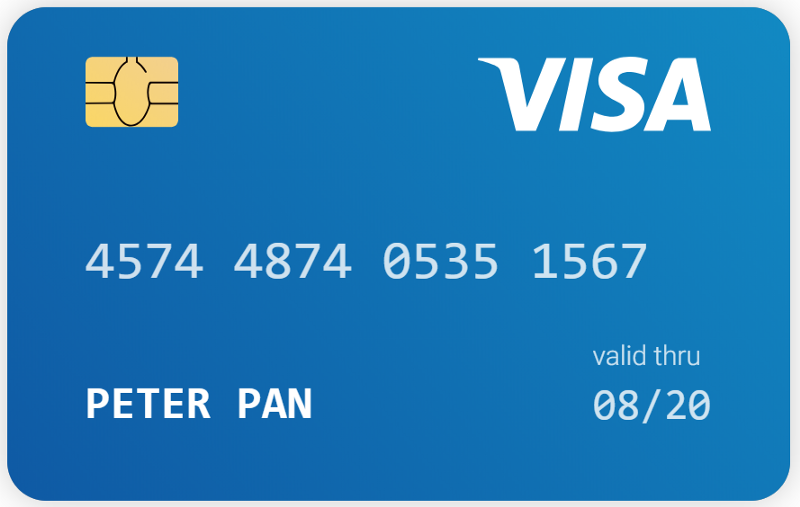

Redacted image:


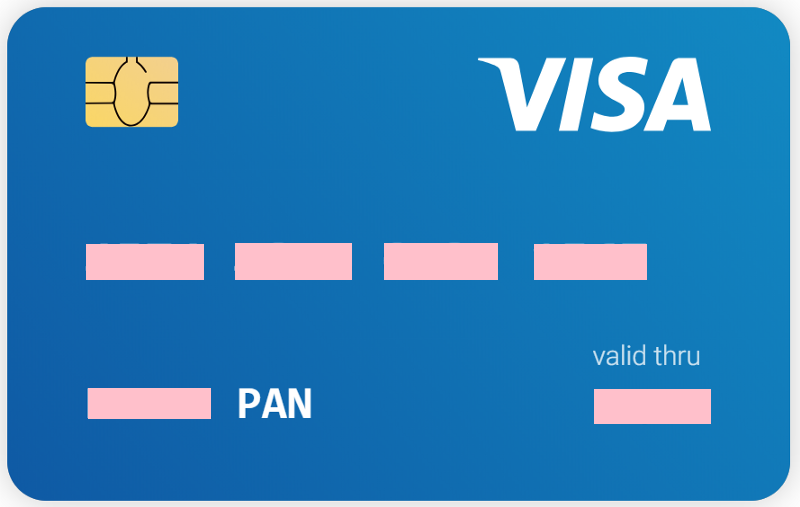

In [102]:
# importing Image class from PIL package 
from PIL import Image 
from presidio_image_redactor import ImageRedactorEngine

print(f'Original Image:')
# creating a object 
image = Image.open(r"dummy_credit_card3.jpg")
#image.show()
display(image)

print(f'Redacted image:')
redactor = ImageRedactorEngine()
# Redact the image with pink color
redacted_image = redactor.redact(image, (255, 192, 203))

# save the redacted image 
redacted_image.save("redacted_image.png")
# uncomment to open the image for viewing
#redacted_image.show()
display(redacted_image)

Original Image:


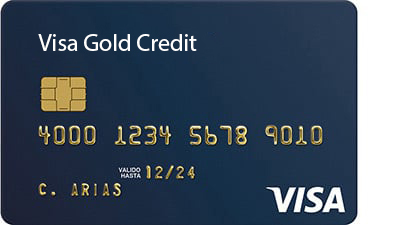

Redacted image:


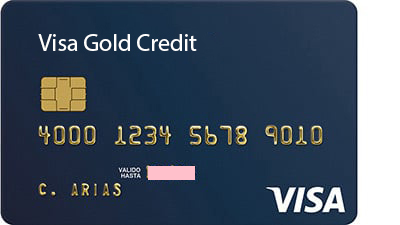

In [103]:
# importing Image class from PIL package 
from PIL import Image 
from presidio_image_redactor import ImageRedactorEngine

print(f'Original Image:')
# creating a object 
image = Image.open(r"dummy_credit_card.jpg")
#image.show()
display(image)

print(f'Redacted image:')
redactor = ImageRedactorEngine()
# Redact the image with pink color
redacted_image = redactor.redact(image, (255, 192, 203))

# save the redacted image 
redacted_image.save("redacted_image.png")
# uncomment to open the image for viewing
#redacted_image.show()
display(redacted_image)

### Observation
- To date (Oct.2023), Presidio Image Redactor is still in beta and not yet production ready (the detection results depends on image resolution / quality, etc.)

# Conclusion
- `Presidio` is a **free and powerful open-source** tool and framework for privacy PII data protection and anonymization, also **extensible and scalable** for new private entity recognition  
- For quick testing, it can be used OOTB to detect most common private entities thanks to a set of its pre-defined recognizers, for 'speed-to-value'   
- For commercial use, due to its automated detection mechanisms, there is **no guarantee** that Presidio will find all sensitive information in text. Thus **extra protection measures** (e.g. human check, build your own custom recognizer to better your domain-specific data, advanced ML models) should be employed for full anonymization! 
- Consider testing each recognizer on a **representative** dataset prior to integrating it into Presidio (refer to [the best practices for developing recognizers documentation](https://microsoft.github.io/presidio/analyzer/developing_recognizers/))  
- For **reproducibility** purposes, it is be best to note how the recognizer's accuracy was tested, and on which datasets   
- For tools and documentation on evaluating and analyzing recognizers, refer to [the presidio-research Github repository](https://github.com/microsoft/presidio-research)